In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/s12gb1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Data preparation

In [2]:
from datasets import load_dataset

imdb = load_dataset("imdb")
train_data, test_data = imdb['train'], imdb['test']

In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer("basic_english")
vocab_size = 20000

def yield_tokens(data_iter):
    for data in data_iter:
        yield tokenizer(data["text"])

vocab = build_vocab_from_iterator(yield_tokens(train_data),
                                  min_freq = 3,
                                  max_tokens=vocab_size,
                                  specials=["<pad>", "</s>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [4]:
seq_length = 500
text_pipeline = lambda x: vocab(tokenizer(x))

def collate_batch(batch, seq_length=500):
    text_list, label_list = [], []
    for sample in batch:
        label_list.append(sample['label'])
        
        text_processed = text_pipeline(sample['text'])[:seq_length]
        if len(text_processed) < seq_length:
            pad_size = seq_length - len(text_processed) - 1
            text_processed = text_processed + [vocab["</s>"]] + [vocab["<pad>"]]*pad_size
        text_list.append(text_processed)

    input_ids = torch.tensor(text_list, dtype=torch.int64)
    labels = torch.tensor(label_list, dtype=torch.int64)
    return input_ids, labels

In [5]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=True)

# 2. Model

In [6]:
class TextClsModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim, num_layers = num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        last_hidden = hidden[-1,:,:] 
        x = self.fc(last_hidden)
        return x


In [7]:
model = TextClsModel(vocab_size=vocab_size, 
                     emb_dim=128, 
                     hidden_dim=64,
                     num_layers=2
                     )

In [8]:
from torchsummary import summary

random_tensor = torch.randint(low=0, high=vocab_size, size=(64, seq_length), dtype=torch.long)
summary(model, random_tensor)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 500, 128]            2,560,000
├─RNN: 1-2                               [-1, 500, 64]             20,736
├─Linear: 1-3                            [-1, 2]                   130
Total params: 2,580,866
Trainable params: 2,580,866
Non-trainable params: 0
Total mult-adds (M): 2.58
Input size (MB): 0.12
Forward/backward pass size (MB): 0.73
Params size (MB): 9.85
Estimated Total Size (MB): 10.70


Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 500, 128]            2,560,000
├─RNN: 1-2                               [-1, 500, 64]             20,736
├─Linear: 1-3                            [-1, 2]                   130
Total params: 2,580,866
Trainable params: 2,580,866
Non-trainable params: 0
Total mult-adds (M): 2.58
Input size (MB): 0.12
Forward/backward pass size (MB): 0.73
Params size (MB): 9.85
Estimated Total Size (MB): 10.70

# 3. Evaluate

In [9]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            test_loss += loss.item()
            correct +=(predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

# 4. Train

In [10]:
device = 'cuda'
max_epoch = 20
LR = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [11]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model.to(device)
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    epoch_loss =  running_loss / len(train_loader)
    epoch_accuracy = 100* running_correct / total
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/20], Loss: 0.7079, Accuracy: 50.07%, Test Loss: 0.7066, Test Accuracy: 49.51%
Epoch [2/20], Loss: 0.7057, Accuracy: 50.54%, Test Loss: 0.7016, Test Accuracy: 50.52%
Epoch [3/20], Loss: 0.7011, Accuracy: 50.99%, Test Loss: 0.7007, Test Accuracy: 50.53%
Epoch [4/20], Loss: 0.6919, Accuracy: 51.60%, Test Loss: 0.7133, Test Accuracy: 50.36%
Epoch [5/20], Loss: 0.6854, Accuracy: 52.56%, Test Loss: 0.7105, Test Accuracy: 49.64%
Epoch [6/20], Loss: 0.6810, Accuracy: 53.34%, Test Loss: 0.7130, Test Accuracy: 50.27%
Epoch [7/20], Loss: 0.6765, Accuracy: 52.94%, Test Loss: 0.7240, Test Accuracy: 50.42%
Epoch [8/20], Loss: 0.6805, Accuracy: 53.17%, Test Loss: 0.7310, Test Accuracy: 50.45%
Epoch [9/20], Loss: 0.6786, Accuracy: 53.27%, Test Loss: 0.7188, Test Accuracy: 50.42%
Epoch [10/20], Loss: 0.6757, Accuracy: 53.29%, Test Loss: 0.7197, Test Accuracy: 50.48%
Epoch [11/20], Loss: 0.6740, Accuracy: 53.18%, Test Loss: 0.7475, Test Accuracy: 50.36%
Epoch [12/20], Loss: 0.6704, Accuracy: 53

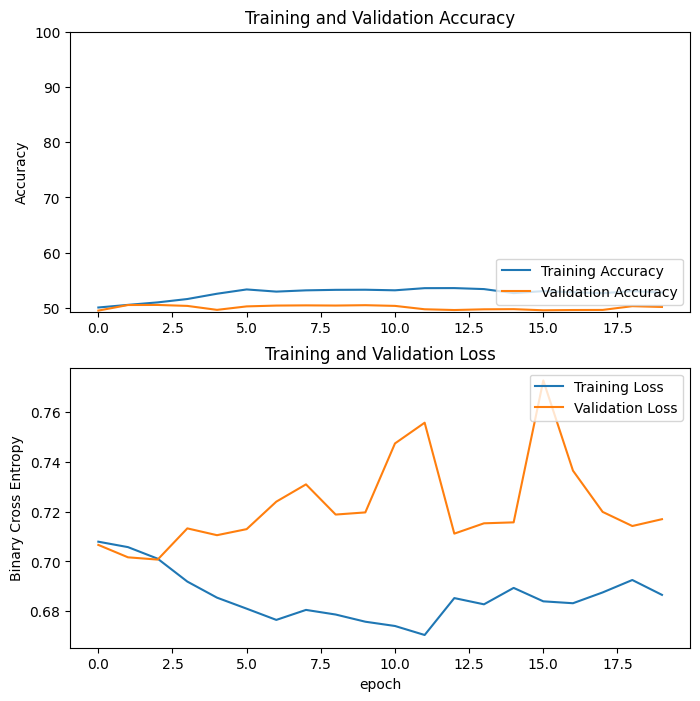

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()